In [32]:
%pip install -q condacolab

import condacolab

condacolab.install()

!conda install -c https://software.repos.intel.com/python/conda -c conda-forge -c ccpi cil=25.0.0

✨🍰✨ Everything looks OK!
Channels:
 - https://software.repos.intel.com/python/conda
 - conda-forge
 - ccpi
Platform: linux-64
Solving environment: \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [2]:
import sys

sys.path.append("/usr/local/lib/python3.11/site-packages")
import cil
print("CIL version:", cil.__version__)

CIL version: 25.0.0


In [ ]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#                   Hannah Robarts (UKRI-STFC)

# Sandstone 2D parallel-beam data reconstruction demo



This exercise walks through the steps needed to load in, preprocess and reconstruct by FBP a 2D parallel-beam data set from a synchrotron of a sandstone sample. Learning objectives are:
- Load and investigate a real data set.
- Determine geometric information of the data and set up CIL data structures.
- Apply CIL processors to pre-process the data, including normalisation, negative log, region-of-interest and centre of rotation correction.
- Compute FBP reconstruction using CIL and compare with reconstruction provided.

This example requires the data in `small.zip` from: https://zenodo.org/record/4912435 :
 - https://zenodo.org/record/4912435/files/small.zip

If running locally please download the data and update the `datapath` variable below.

In [3]:
!wget https://zenodo.org/record/4912435/files/small.zip
!unzip -q small.zip -d small_data

--2025-10-28 11:22:40--  https://zenodo.org/record/4912435/files/small.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4912435/files/small.zip [following]
--2025-10-28 11:22:40--  https://zenodo.org/records/4912435/files/small.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 207330794 (198M) [application/octet-stream]
Saving to: ‘small.zip’

small.zip           100%[===================>] 197.73M  1.53MB/s    in 3m 7s   

2025-10-28 11:25:48 (1.06 MB/s) - ‘small.zip’ saved [207330794/207330794]



In [4]:
datapath = "/content/small_data"

In [ ]:
!conda install -c astra-toolbox astra-toolbox

Channels:
 - astra-toolbox
 - conda-forge
 - ccpi
 - https://software.repos.intel.com/python/conda
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [5]:
# Import all CIL components needed
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

# CIL Processors
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter, Normaliser, Padder

# CIL display tools
from cil.utilities.display import show2D, show_geometry

# CIL FBP
from cil.recon import FBP

In [ ]:
# From CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

ImportError: cannot import name 'astra_c' from partially initialized module 'astra' (most likely due to a circular import) (/usr/local/lib/python3.11/site-packages/astra/__init__.py)

In [6]:
# All external imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

Switch on printing of more info in some of the methods including `CentreOfRotationCorrector`:

In [7]:
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

The data contains selected 2D projections, flat and dark fields, as well as complete 2D sinograms for 4 horizontal slices. We first load and display a couple of projections

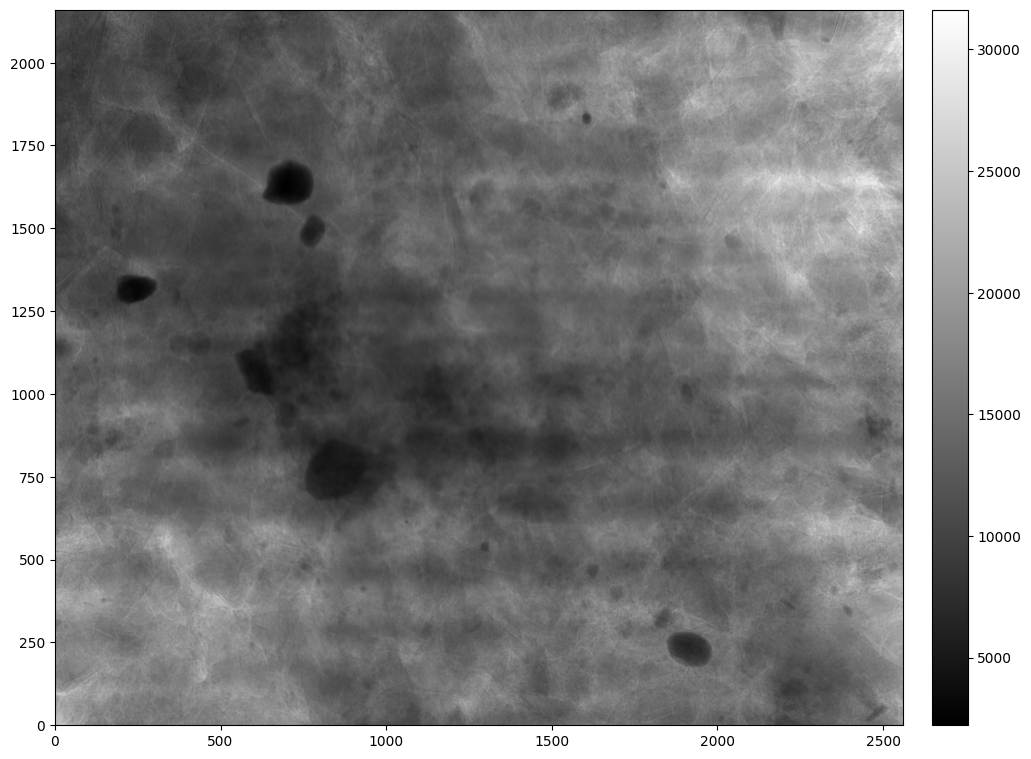

In [8]:
proj1 = plt.imread(os.path.join(datapath,"proj","BBii_0131.tif"))
show2D(proj1)

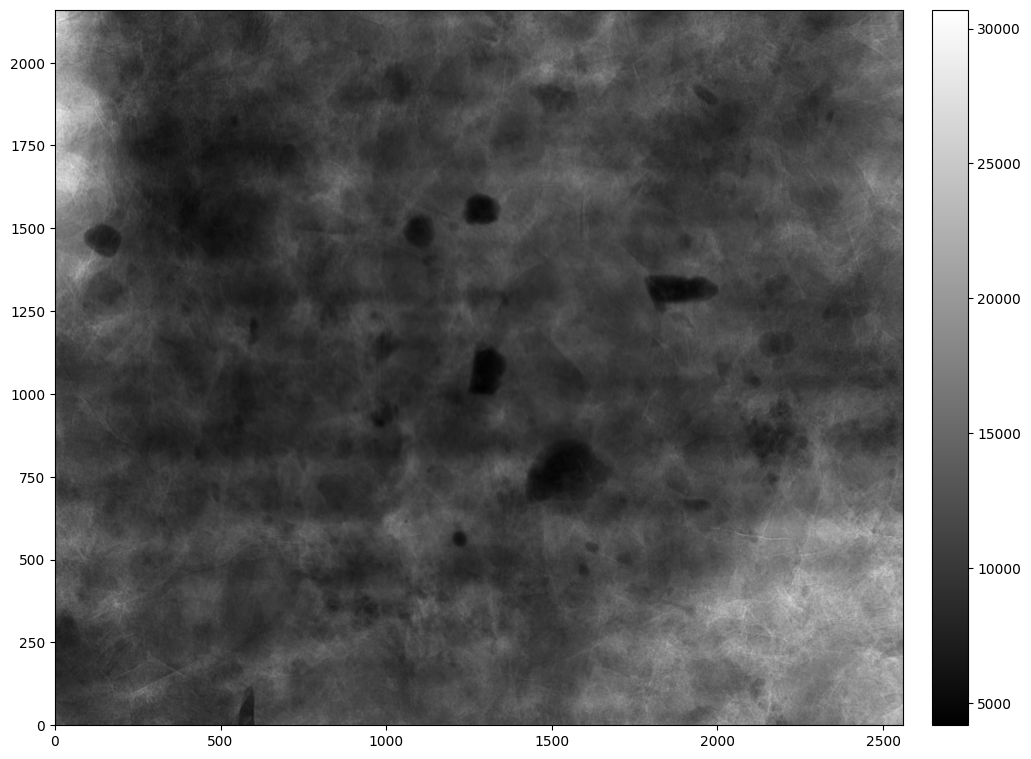

In [11]:
proj2 = plt.imread(os.path.join(datapath,"proj","BBii_0931.tif"))
show2D(proj2)

We also load and display a flat field (image taken before projections with source on, and sample out):

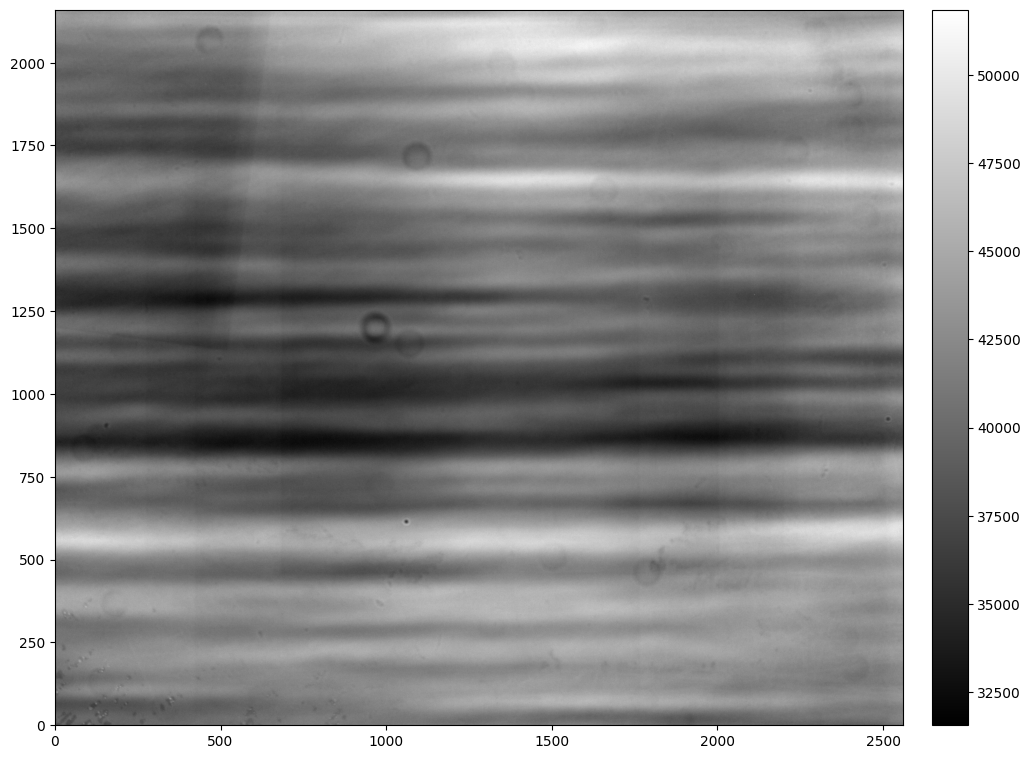

In [12]:
flat1 = plt.imread(os.path.join(datapath,"proj","BBii_0031.tif"))
show2D(flat1)

We also load and display a dark field (image taken before projections and flat with source off, and sample out, to capture any background counts):

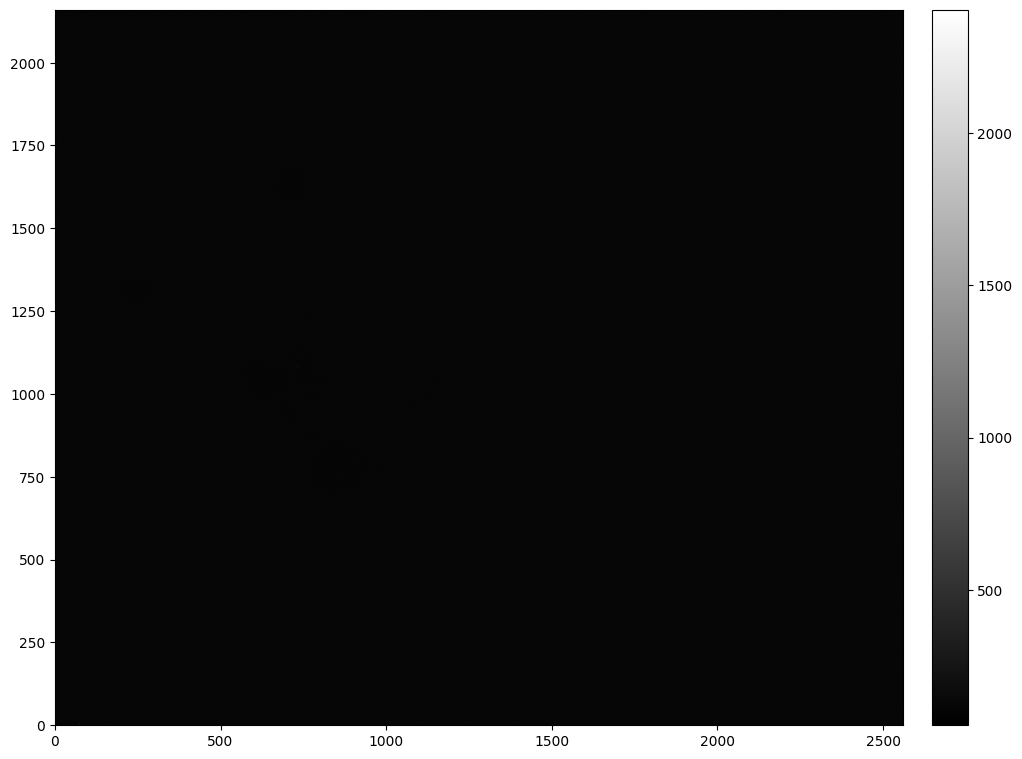

In [13]:
dark1 = plt.imread(os.path.join(datapath,"proj","BBii_0002.tif"))
show2D(dark1)

Projections have 2160 rows and 2560 columns as seen by:

In [14]:
proj1.shape

(2160, 2560)

For convenience sinograms for four selected slices have been extracted from the full 1500 projections and are provided as mat-files. We choose one and load it:

Load demo data set and display the first raw projection

In [15]:
filename = "slice_0270_data.mat"
all_data = scipy.io.loadmat(os.path.join(datapath,filename))

The data contains projections, flats and darks for the selected slice. There are 1500 projections of size 2560 pixels:

In [16]:
projs = all_data['X_proj'].astype(np.float32)
projs.shape

(2560, 1500)

There are 200 flats (100 taken before, and 100 taken after the projections):

In [17]:
flats = all_data['X_flat'].astype(np.float32)
flats.shape

(2560, 200)

There are 30 darks taken at the beginning of the experiment:

In [18]:
darks = all_data['X_dark'].astype(np.float32)
darks.shape

(2560, 30)

The data provided also contains the reconstruction produced at the synchrotron where the data was acquired. We load and display it to see what kind of image we aim to reconstruct:

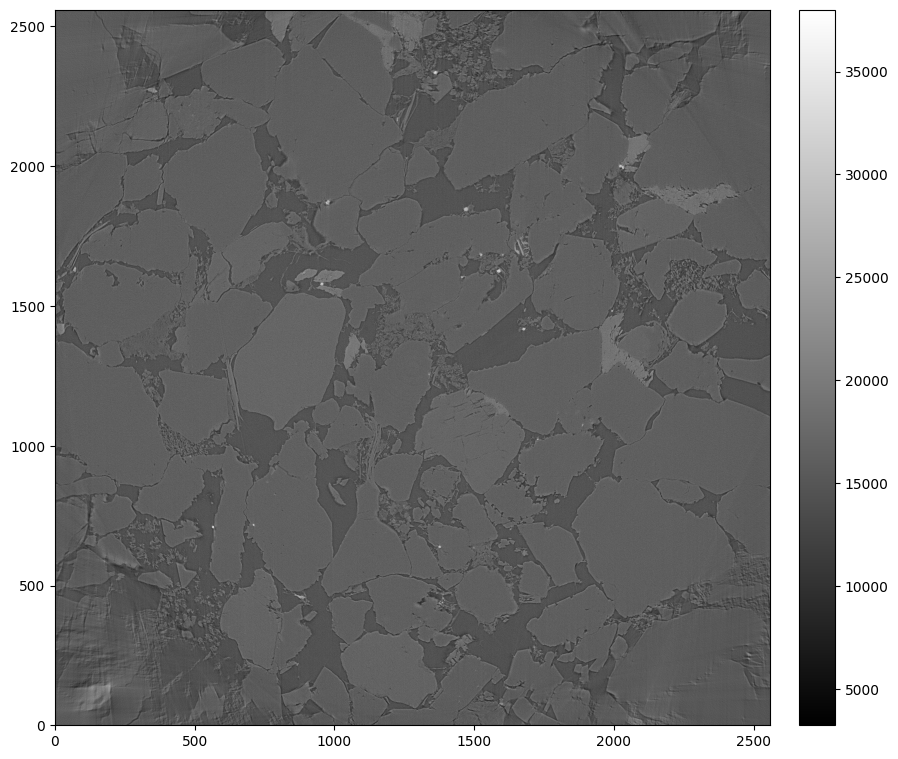

In [19]:
vendor_recon = plt.imread(os.path.join(datapath,"recon","BBii_0270.rec.16bit.tif"))
show2D(np.rot90(vendor_recon))

OK, we have now taken a look at the data and are ready to start producing our own reconstruction. We need to go through a number of steps to get there.

As a first step toward reconstructing the data, we specify the CIL `AcquisitionGeometry` for a 2D parallel-beam geometry with 1500 projections over 0 to 180 degrees each consisting of 2560 detector pixels.

In [20]:
ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2560))        \
         .set_angles(angles=np.linspace(0,180,1500,endpoint=False))

We can illustrate the geometry specified:

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

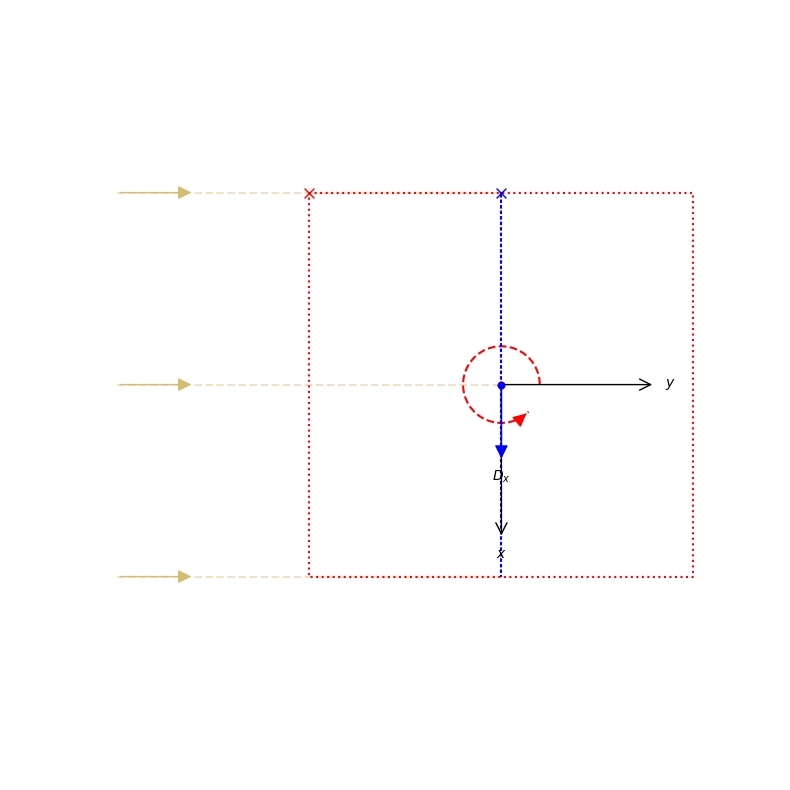

In [21]:
show_geometry(ag)

To create the CIL data structure `AcquisitionData` holding the data we check again the size of the projections

In [22]:
projs.shape

(2560, 1500)

so along the first dimension are the horizontal detector pixels and along the second the projections/angles. We then tell CIL which axes are which:

In [23]:
ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)

(<AcquisitionDimension.HORIZONTAL: 'horizontal'>, <AcquisitionDimension.ANGLE: 'angle'>)


Now we create an `AcquisitionData` holding the projections and the geometry. We link the `projs` numpy array to the `AcquisitionData` without creating an additional copy.

In [24]:
data = AcquisitionData(projs, geometry=ag, deep_copy=False)

We can take a look with the CIL `show2D` display function:

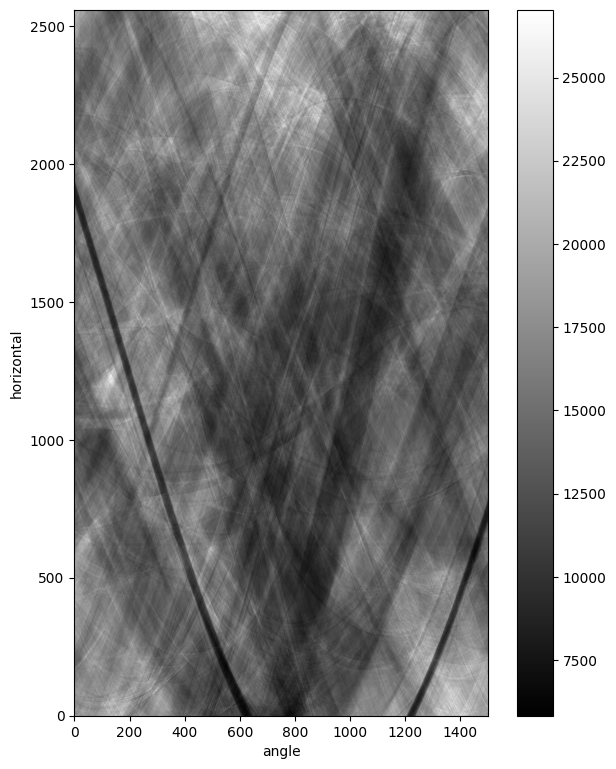

In [25]:
show2D(data)

Let us try reconstructing straight from the raw projections. First we need to make sure the data matches the order expected by the ASTRA-Toolbox plugin. We use `reorder('astra')` to check and reorder the data if required.

In [29]:
data.reorder('astra')

Now we must specify the `ImageGeometry` we want for the reconstruction grid, here we choose the default which can be generated from the `AcquisitionGeometry`:

In [27]:
ig = ag.get_ImageGeometry()

We set up and run the FBP reconstructor with our dataset and specify the backend to use:

In [33]:
rec1 = FBP(data, ig, backend='astra').run()

/usr/local/lib/python3.11/site-packages/cil/optimisation/operators/DiagonalOperator.py:53: SyntaxWarning: invalid escape sequence '\c'
  "Returns :math:`D\circ x` "
/usr/local/lib/python3.11/site-packages/cil/optimisation/operators/DiagonalOperator.py:61: SyntaxWarning: invalid escape sequence '\c'
  "Returns :math:`D^*\circ x` "


ModuleNotFoundError: No module named 'astra'

In [34]:
show2D(rec1)

NameError: name 'rec1' is not defined

On close inspection we see some of the right features but distorted and wrong colours. The first thing we are missing is to normalise the data, i.e., apply flat and dark field correction. This is achieved by the CIL `Normaliser` processor and we simply use the mean over the flat and dark images respectively:

In [ ]:
data2 = Normaliser(flat_field=flats.mean(axis=1),
                   dark_field=darks.mean(axis=1)
                  )(data)

In [ ]:
show2D(data2)

Compared to the previous sinogram of the raw projections, we see on the colourbar that the range is now within 0 to 1 as is what we need. We try reconstructing again:

In [ ]:
rec2 = FBP(data2, ig, backend='astra').run()

In [ ]:
show2D(rec2)

NameError: name 'show2D' is not defined

It looks that same, only has the range change as seen on the colourbar. We realise that we need to apply the negative logarithm according to the Lambert-Beer law, which can be done manually or using a CIL `Processor`, which will prevent outliers and zeros from causing trouble:

In [ ]:
data3 = TransmissionAbsorptionConverter()(data2)

NameError: name 'TransmissionAbsorptionConverter' is not defined

In [ ]:
show2D(data3)

We see the data has been transformed so the big sine band shows up white instead of dark as before. We attempt reconstructing:

In [ ]:
rec3 = FBP(data3, ig, backend='astra').run()

NameError: name 'FBP' is not defined

In [ ]:
show2D(rec3)

The colours have flipped now, so it is a step forward, but there is a big white ring. This is because the data is region-of-interest, i.e., the sample was larger than the field of view, so projections are truncated (i.e. do not have air on both sides as also seen in the sinograms). A simple way to compensate for this is to extend or pad the data on both sides of the projections. Using the CIL `Padder` processor we can for example pad by the left and rightmost pixel values, and we can play with the amount of padding required to push the ring out of the reconstruction. A `padsize` of about 600 is required:

In [ ]:
padsize = 600
data4 = Padder.edge(pad_width={'horizontal': padsize})(data3)

In [ ]:
show2D(data4)

We see the data has been extended left and right. In effect the sinogram is now larger, so we need to create a new FBP reconstructor configured for the new padded data. We keep the reconstruction volume (defined by our image geometry) the same as before as we are not interested in the extended region.

In [ ]:
rec4 = FBP(data4, ig, backend='astra').run()

In [ ]:
show2D(rec4)

With `padsize=600` we see the region-of-interest ring has been successfully moved out and the sample features are more clearly seen. However there are still artifacts in the form of U-shaped stripes. These are centre-of-rotation artifacts caused by the sample not being perfectly centered during scanning. The log file of the dataset provides the centre value that was determined at the synchrotron. Here we use a CIL `Processor` to determine the offset and update the geometry. It works by doing FBP reconstructions for a range of offset parameters, evaluates a quality metric based on image sharpness and searches for the best offset. This technique is designed for use when you have 360 degrees of data, but can be applied to 180 degrees but will be very sample dependent.

In [ ]:
data5 = CentreOfRotationCorrector.image_sharpness(backend='astra', search_range=100, tolerance=0.1)(data4)

We can compute the centre of rotation from a CIL geometry. The argument `distance_units` allows you to define the units of the returned value. Here we specify pixels.

In [ ]:
data5.geometry.get_centre_of_rotation(distance_units='pixels')

In [ ]:
rec5 = FBP(data5, ig, backend='astra').run()

In [ ]:
show2D(rec5)

This reproduces the result from the synchrotron quite well, we show it again here for comparison:

In [ ]:
show2D(np.rot90(vendor_recon))

Should the centre of rotation correction method fail, one can manually specify a rotation axis offset and carry out reconstruction in the following way. In this way, one may experiment with different offsets and manually search for a suitable value by visual inspection of the resulting reconstructions as function of the offset.

**Try to find the correct axis offset within the range -100 to 100 pixels.**

Make a copy of the dataset first:

In [ ]:
data_cor_manual = data4.copy()

Then update the geometry with different centre of rotation offsets:

In [ ]:
offset = 0
data_cor_manual.geometry.set_centre_of_rotation(offset, distance_units='pixels')

Compute FBP reconstruction and display assessing the output by eye:

In [ ]:
rec_cor_manual = FBP(data_cor_manual, ig, backend='astra').run()

show2D(rec_cor_manual)